# XBEACH procedural example

In this notebook we will use the rompy-xbeach and data objects to define an XBEACH workspace

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shutil
from pathlib import Path
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

In [3]:
def generate_output_directory(path="example-procedural"):
    """Generate the output dir for the examples, removing it if it already exists."""
    outdir = Path(path)
    if outdir.exists():
        shutil.rmtree(outdir)
    outdir.mkdir()
    return outdir

## Workspace basepath

In [4]:
# workdir = Path("example_procedural")
# shutil.rmtree(workdir, ignore_errors=True)
# workdir.mkdir()

## Model Times

Define a TimeRange object to generate the input data and run the simulation.
The simulation length (`tstop`) will be defined by the range in this object while the
time frequency will define the resolution of the model output (`NotImplemented`)

In [5]:
from rompy.core.time import TimeRange

times = TimeRange(start="2023-01-01T00", end="2023-01-02T00", freq="1h")
times

TimeRange(start=datetime.datetime(2023, 1, 1, 0, 0), end=datetime.datetime(2023, 1, 2, 0, 0), duration=datetime.timedelta(days=1), interval=datetime.timedelta(seconds=3600), include_end=True)

## Model Grid

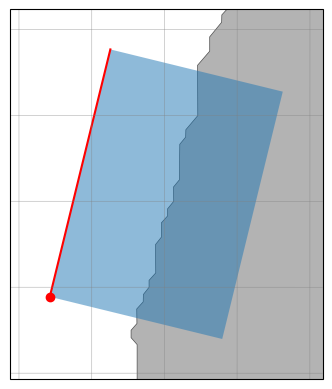

In [6]:
from rompy_xbeach.grid import RegularGrid, GeoPoint

grid = RegularGrid(
    ori=GeoPoint(x=115.594239, y=-32.641104, crs="EPSG:4326"),
    alfa=347.0,
    dx=10.0,
    dy=15.0,
    nx=230,
    ny=220,
    crs="EPSG:28350"
)

ax = grid.plot(scale="f")

## Work with existing data

Check the data from the rompy-xbeach tests. We will use some subset Lidar data publicly
available from the Australian Department of Transport to generate the model bathymetry

In [7]:
# Assumes rompy-xbeach is cloned at the same level as the rompy-notebooks repo
DATADIR = Path("../../../rompy-xbeach/tests/data")
display(sorted(DATADIR.glob("*")))

[PosixPath('../../../rompy-xbeach/tests/data/aus-20230101.nc'),
 PosixPath('../../../rompy-xbeach/tests/data/bathy.nc'),
 PosixPath('../../../rompy-xbeach/tests/data/bathy.tif'),
 PosixPath('../../../rompy-xbeach/tests/data/bathy.zarr'),
 PosixPath('../../../rompy-xbeach/tests/data/bathy.zip'),
 PosixPath('../../../rompy-xbeach/tests/data/bathy_xyz.zip'),
 PosixPath('../../../rompy-xbeach/tests/data/catalog.yaml'),
 PosixPath('../../../rompy-xbeach/tests/data/era5-20230101.nc'),
 PosixPath('../../../rompy-xbeach/tests/data/smc-params-20230101.nc'),
 PosixPath('../../../rompy-xbeach/tests/data/smc-params.nc'),
 PosixPath('../../../rompy-xbeach/tests/data/ssh.csv'),
 PosixPath('../../../rompy-xbeach/tests/data/ssh_gridded.nc'),
 PosixPath('../../../rompy-xbeach/tests/data/ssh_stations.nc'),
 PosixPath('../../../rompy-xbeach/tests/data/swaus_tide_cons'),
 PosixPath('../../../rompy-xbeach/tests/data/tide_cons_station.csv'),
 PosixPath('../../../rompy-xbeach/tests/data/wave-params-20230101.

### Bathy


#### Inspecting the data

Load the bathy file with xarray just to inspect

In [8]:
bathyfile = DATADIR / "bathy.tif"
bathy = xr.open_dataset(bathyfile, engine="rasterio")
display(bathy)

<xarray.Dataset> Size: 130kB
Dimensions:      (band: 1, x: 176, y: 180)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 1kB 115.6 115.6 115.6 115.6 ... 115.6 115.6 115.6
  * y            (y) float64 1kB -32.65 -32.65 -32.65 ... -32.61 -32.61 -32.61
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 127kB ...

Plot the grid and bathy together

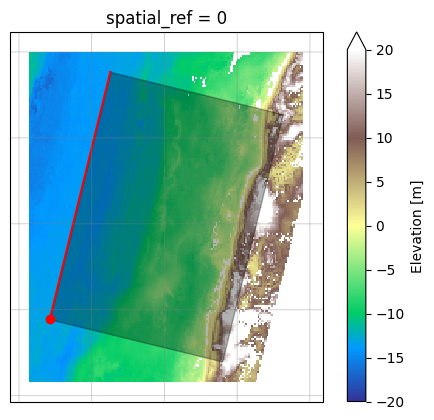

In [9]:
fig, ax = plt.subplots(figsize=None, subplot_kw=dict(projection=grid.projection))
p = bathy.band_data.isel(band=0, drop=True).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="terrain",
    vmin=-20,
    vmax=20,
    cbar_kwargs=dict(label="Elevation [m]")
)
ax = grid.plot(
    ax=ax,
    grid_kwargs=dict(facecolor="k", edgecolor="k", alpha=0.3),
)

#### Create the bathy data instance

The bathy data instance will be used to define the rompy-xbeach model config. We start
off by defining a source instance which can be passed to `XBeachBathy`. The SourceGeotiff
source can be used to handle a geotiff file

In [10]:
from rompy_xbeach.source import SourceGeotiff

source = SourceGeotiff(filename=bathyfile)
source

SourceGeotiff(model_type='geotiff', filename=PosixPath('../../../rompy-xbeach/tests/data/bathy.tif'), band=1, kwargs={})

Then we define an interpolator instance. The interpolator takes care of the data interpolation
onto the model grid to create the model files. There is one interpolator type
`RegularGridInterpolator` currently implemented in rompy-xbeach

In [11]:
from rompy_xbeach.interpolate import RegularGridInterpolator

interpolator = RegularGridInterpolator(
    kwargs=dict(
        method="linear",
        fill_value=None,
    ),
)
interpolator

RegularGridInterpolator(model_type='scipy_regular_grid', kwargs={'method': 'linear', 'fill_value': None})

In order to allow the grid to be extended offshore so it has homogeneous depth at the
boundary, we need to specify how the extension should be performed. We do this using a
`SeawardExtension` object. A linear extension type is currently available in rompy-xbeach
which calculates the extension length based on the extension slope and depth provided,
together with the shallowest depth in the existing (non-extended) offshore boundary 

In [12]:
from rompy_xbeach.data import SeawardExtensionLinear

extension = SeawardExtensionLinear(
    depth=25,
    slope=0.1,
)
extension

SeawardExtensionLinear(model_type='linear', depth=25.0, slope=0.1)

Now we are ready to instantiate the XBeach bathy data instance, we are going to work
with `XBeachBathy` and specify the objects created above with some additional information
include posdwn (tells if depths are positive down or not) and parameters for a lateral extension

In [13]:
from rompy_xbeach.data import XBeachBathy

bathy = XBeachBathy(
    source=source,
    posdwn=False,
    interpolator=interpolator,
    extension=extension,
    left=5,
    right=5,
)
bathy

XBeachBathy(model_type='xbeach_bathy', id='data', source=SourceGeotiff(model_type='geotiff', filename=PosixPath('../../../rompy-xbeach/tests/data/bathy.tif'), band=1, kwargs={}), link=False, filter=Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}), variables=['data'], coords=DatasetCoords(t='time', x='longitude', y='latitude', z='depth', s='site'), crop_data=True, buffer=0.0, time_buffer=[0, 0], interpolator=RegularGridInterpolator(model_type='scipy_regular_grid', kwargs={'method': 'linear', 'fill_value': None}), posdwn=False, left=5, right=5, extension=SeawardExtensionLinear(model_type='linear', depth=25.0, slope=0.1), interpolate_na=True, interpolate_na_kwargs={})

At this stage we are all set to define the bathymetry in the XBeach config. However it
can be useful to generate the actual bathymetry data to check and tweak if necessary

In [14]:
destdir = generate_output_directory()

xfile, yfile, depfile, grid_extended = bathy.get(
    destdir=destdir,
    grid=grid,
)
print(depfile.absolute())

/source/csiro/rompy-notebooks/notebooks/xbeach/example-procedural/bathy.txt


The xbeach accessor provides methods to create and plot a Dataset from the datafiles

<xarray.Dataset> Size: 1MB
Dimensions:      (y: 230, x: 242)
Coordinates:
    xc           (y, x) float64 445kB 3.68e+05 3.68e+05 ... 3.711e+05 3.711e+05
    yc           (y, x) float64 445kB 6.388e+06 6.388e+06 ... 6.39e+06 6.39e+06
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Data variables:
    dep          (y, x) float64 445kB -25.0 -24.01 -23.02 ... 14.63 14.45 14.53

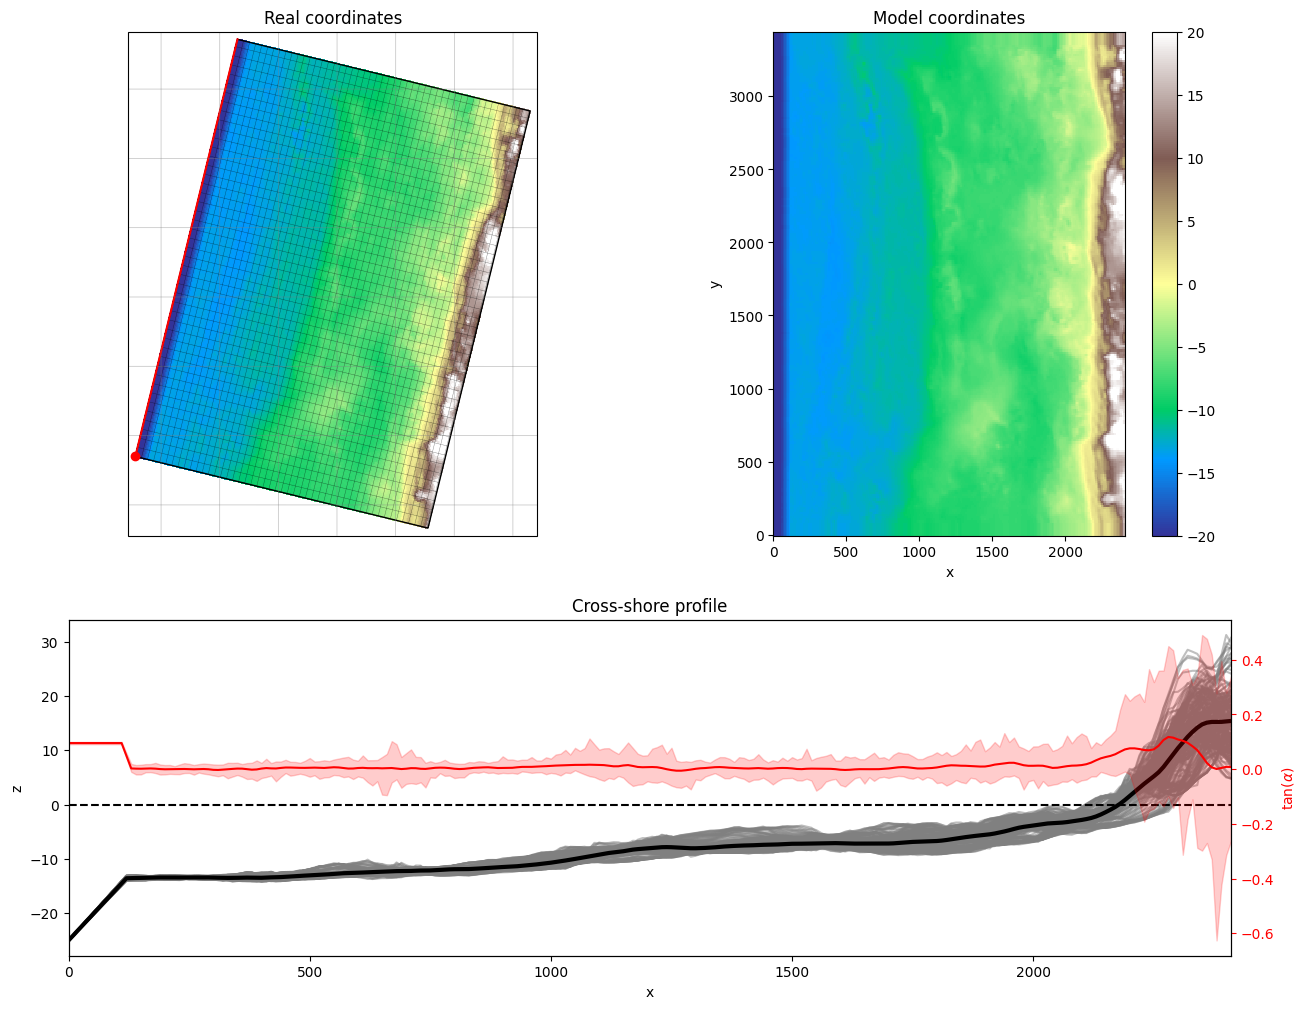

In [15]:
dset = xr.Dataset.xbeach.from_xbeach(depfile, grid_extended)
display(dset)
dset.xbeach.plot_model_bathy(grid_extended, posdwn=False)

### Wave boundary

Wave boundary can be defined from existing data using the boundary data objects. Here
we are going to define SWAN type spectral boundary from a stations-type (SMC) spectral
datasource

In [16]:
from rompy_xbeach.source import SourceCRSWavespectra
from rompy_xbeach.boundary import BoundaryStationSpectraSwan

In [17]:
# Define the source of the wave spectra

source = SourceCRSWavespectra(
    uri=DATADIR / "ww3-spectra-20230101.nc",
    reader="read_ww3",
)
source


# Define the wave boundary instance

wave = BoundaryStationSpectraSwan(source=source)

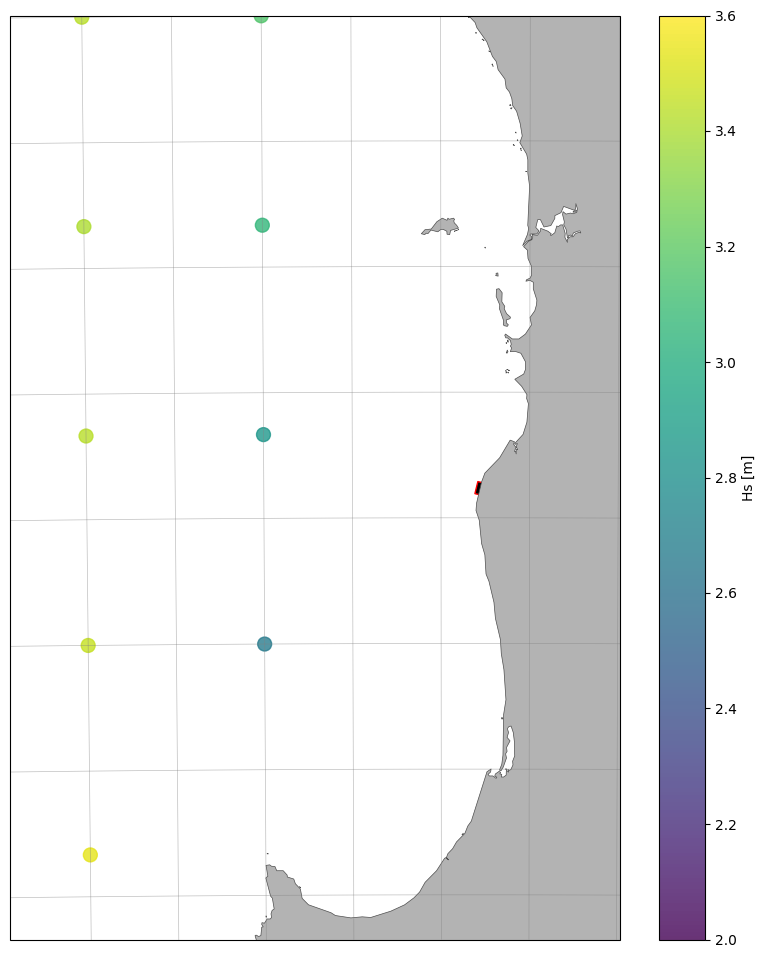

In [18]:
# Calculate and plot Hs for the first model time

ds = source.open().sel(time=times.start).squeeze()
fig, ax = plt.subplots(subplot_kw=dict(projection=grid.projection), figsize=(10, 12))
p = ax.scatter(
    ds.lon,
    ds.lat,
    s=100,
    c=ds.spec.hs(),
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    vmin=2.0,
    vmax=3.6,
    alpha=0.8,
)
ax = grid.plot(
    ax=ax,
    scale="h",
    grid_kwargs=dict(facecolor="black", edgecolor="red", alpha=1.0),
    # buffer=100000,
    set_extent=False,
    set_gridlines=False,
    show_offshore=False,
    show_origin=False,
)
plt.colorbar(p, label="Hs [m]")

ax.set_extent([114.3, 116, -33.7, -31.5], crs=ccrs.PlateCarree())

### Wind

Wind data objects are available to define wind input at the centre or the offshore
boundary of the XBeach model grid from gridded or stations type datasources. Here we
will work with an stations type file.

In [19]:
from rompy_xbeach.source import SourceCRSFile
from rompy_xbeach.forcing import WindStation, WindVector

In [20]:
# Define the source of the wind data

source = SourceCRSFile(
    uri=DATADIR / "smc-params-20230101.nc",
    crs=4326,
)

# Define the wind station instance, use the WindVector class
# to define the wind components since this data source contains wind vectors

wind = WindStation(
    source=source,
    coords=dict(s="seapoint"),
    wind_vars=WindVector(u="uwnd", v="vwnd"),
)


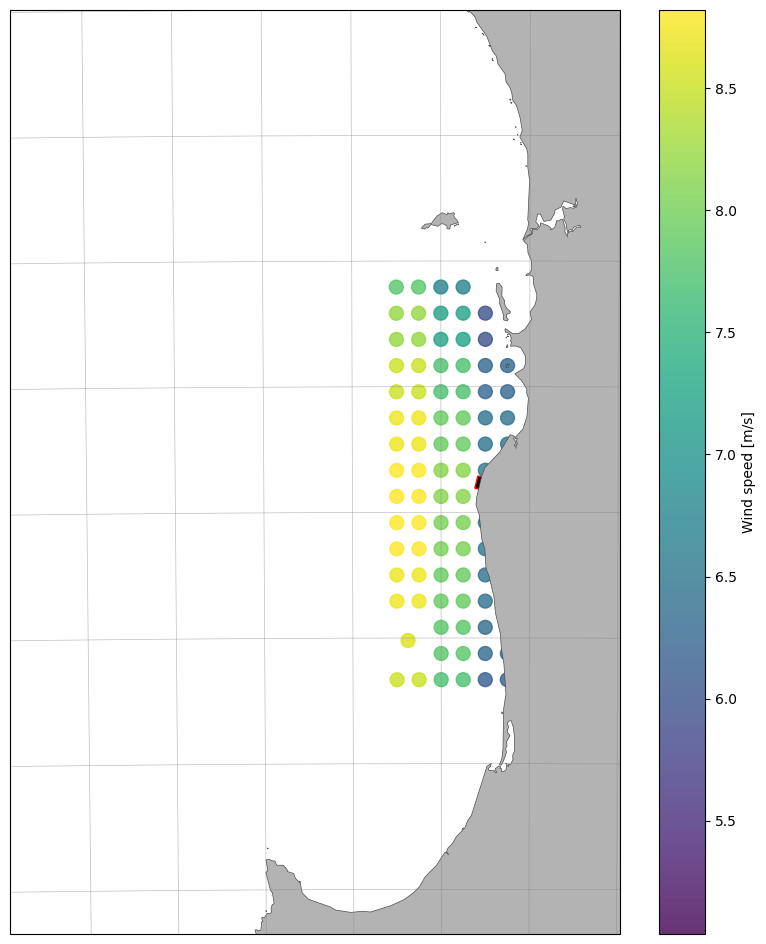

In [21]:
# Calculate and plot wind speeds for the first model time

ds = source.open().sel(time=times.start).squeeze()

fig, ax = plt.subplots(subplot_kw=dict(projection=grid.projection), figsize=(10, 12))
ax = grid.plot(
    ax=ax,
    scale="h",
    grid_kwargs=dict(facecolor="black", edgecolor="red", alpha=1.0),
    set_extent=False,
    set_gridlines=False,
    show_offshore=False,
    show_origin=False,
)
p = ax.scatter(
    ds.longitude,
    ds.latitude,
    s=100,
    c=(ds.uwnd ** 2 + ds.vwnd ** 2) ** 0.5,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    vmin=None,
    vmax=None,
    alpha=0.8,
)
plt.colorbar(p, label="Wind speed [m/s]")

ax.set_extent([114.3, 116, -33.7, -31.5], crs=ccrs.PlateCarree())

### Tide

Tide timeseries can be constructed from constituents data supported by oceantide such
as TPXO9


In [22]:
from rompy_xbeach.source import SourceCRSOceantide
from rompy_xbeach.forcing import TideConsGrid

In [23]:
# Define the source of the tide data

source = SourceCRSOceantide(
    reader="read_otis_binary",
    kwargs=dict(
        gfile=DATADIR / "swaus_tide_cons/grid_m2s2n2k2k1o1p1q1mmmf",
        hfile=DATADIR / "swaus_tide_cons/h_m2s2n2k2k1o1p1q1mmmf",
        ufile=DATADIR / "swaus_tide_cons/u_m2s2n2k2k1o1p1q1mmmf",
    ),
    crs=4326,
)

# Define the wind station instance, use the WindVector class
# to define the wind components since this data source contains wind vectors

tide = TideConsGrid(
    source=source,
    coords=dict(x="lon"),
)

## XBEACH parameters

The grid and bathy data objects created above are used in the XBeach Config object
to define the required parameters defined in those objects. The other model parameters
are specified directly by fields in the Config class which define available options for
these parameters where appropriate

In [24]:
from rompy_xbeach.config import Config

Config?

Init signature:
Config(
    *,
    model_type: Literal['xbeach'] = 'xbeach',
    template: str = '/source/csiro/rompy-xbeach/src/rompy_xbeach/templates/base',
    checkout: Optional[str] = 'main',
    grid: rompy_xbeach.grid.RegularGrid,
    bathy: rompy_xbeach.data.XBeachBathy,
    input: rompy_xbeach.config.DataInterface,
    zs0: Annotated[Optional[float], Ge(ge=-5.0), Le(le=5.0)] = None,
    front: Optional[Literal['abs_1d', 'abs_2d', 'wall', 'wlevel', 'nonh_1d', 'waveflume']] = None,
    back: Optional[Literal['wall', 'abs_1d', 'abs_2d', 'wlevel']] = None,
    left: Optional[Literal['neumann', 'wall', 'no_advec', 'neumann_v', 'abs_1d']] = None,
    right: Optional[Literal['neumann', 'wall', 'no_advec', 'neumann_v', 'abs_1d']] = None,
    lateralwave: Optional[Literal['neumann', 'wavecrest', 'cyclic']] = None,
    rugdepth: Annotated[Optional[float], Ge(ge=0.0), Le(le=1.0)] = None,
    tunits: Optional[str] = None,
    breaktype: Optional[Literal['roelvink1', 'baldock', 'roelvink2'

### Instantiate the XBeach config

In [25]:
config = Config(
    grid=grid,
    bathy=bathy,
    input=dict(wave=wave, wind=wind, tide=tide),
    front="abs_2d",
    back="abs_2d",
    left="neumann",
    right="neumann",
    rugdepth=0.011,
    # breaktype="roelvink_daly",
    scheme="warmbeam",
    order=1,
    lateralwave="wavecrest",
    random=True,
    zs0=0.0,
    hmin=0.01,
    wci=False,
    alpha=1,
    delta=0.0,
    n=10,
    rho=1025,
    g=9.81,
    thetamin=-80,
    thetamax=80,
    dtheta=10.0,
    beta=0.1,
    roller=True,
    gamma=0.55,
    gammax=1.0,
    sedtrans=False,
    morfac=1.0,
    morphology=False,
    cf=0.01,
    paulrevere="land",
    eps=0.01,
    epsi=0.001,
    cfl=0.8,
    umin=0.1,
    oldhu=True,
    tstart=0,
    tintm=3600.0,
    outputformat="netcdf",
    ncfilename="xboutput_test.nc",
)

### Generate workspace

In [26]:
from rompy.model import ModelRun

In [27]:
output_dir = generate_output_directory()

modelrun = ModelRun(
    run_id="test1",
    period=times,
    output_dir=output_dir,
    config=config,
)

rundir = modelrun()

INFO:rompy.model:
INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Model settings:
INFO:rompy.model:
run_id: test1
period: 
	Start: 2023-01-01 00:00:00
	End: 2023-01-02 00:00:00
	Duration: 1 day, 0:00:00
	Interval: 1:00:00
	Include End: True

output_dir: example-procedural
config: <class 'rompy_xbeach.config.Config'>

INFO:rompy.model:-----------------------------------------------------
INFO:rompy.model:Generating model input files in example-procedural
INFO:rompy_xbeach.config:Generating wave boundary data
INFO:rompy_xbeach.config:Generating wind forcing data
INFO:rompy_xbeach.config:Generating tide forcing data
INFO:rompy.model:
INFO:rompy.model:Successfully generated project in /source/csiro/rompy-notebooks/notebooks/xbeach/example-procedural/test1
INFO:rompy.model:-----------------------------------------------------


### Check the workspace

In [28]:
modeldir = Path(modelrun.output_dir) / modelrun.run_id

sorted(modeldir.glob("*"))

[PosixPath('example-procedural/test1/bathy.txt'),
 PosixPath('example-procedural/test1/params.txt'),
 PosixPath('example-procedural/test1/swan-20230101T000000.txt'),
 PosixPath('example-procedural/test1/swan-20230101T030000.txt'),
 PosixPath('example-procedural/test1/swan-20230101T060000.txt'),
 PosixPath('example-procedural/test1/swan-20230101T090000.txt'),
 PosixPath('example-procedural/test1/swan-20230101T120000.txt'),
 PosixPath('example-procedural/test1/swan-20230101T150000.txt'),
 PosixPath('example-procedural/test1/swan-20230101T180000.txt'),
 PosixPath('example-procedural/test1/swan-20230101T210000.txt'),
 PosixPath('example-procedural/test1/swan-filelist.txt'),
 PosixPath('example-procedural/test1/tide-20230101T000000-20230102T000000.txt'),
 PosixPath('example-procedural/test1/wind-20230101T000000-20230102T000000.txt'),
 PosixPath('example-procedural/test1/xdata.txt'),
 PosixPath('example-procedural/test1/ydata.txt')]

In [29]:
params = modeldir / "params.txt"
print(params.read_text())

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%% XBeach parameter settings input file
%%%
%%% Date: 2025-04-04 00:21:33.156106
%%% User: rafael-XPS
%%% Template: /source/csiro/rompy-xbeach/src/rompy_xbeach/templates/base
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

zs0 = 0.0
front = abs_2d
back = abs_2d
left = neumann
right = neumann
lateralwave = wavecrest
rugdepth = 0.011
scheme = warmbeam
order = 1
random = 1
hmin = 0.01
wci = 0
alpha = 1.0
delta = 0.0
n = 10.0
rho = 1025.0
g = 9.81
thetamin = -80.0
thetamax = 80.0
dtheta = 10.0
beta = 0.1
roller = 1
gamma = 0.55
gammax = 1.0
sedtrans = 0
morfac = 1.0
morphology = 0
cf = 0.01
eps = 0.01
epsi = 0.001
cfl = 0.8
umin = 0.1
oldhu = 1
outputformat = netcdf
ncfilename = xboutput_test.nc
tstart = 0.0
tintm = 3600.0
paulrevere = land
tstop = 86400.0
tunits = seconds since 2023-01-01 00:00:00
wbctype = swan
bcfile = swan-filelist.txt
windfile = wind-20230101T000000-20230102T00000

## Check the input

In [30]:
def read_xbeach_input(modelrun: ModelRun, filetype: str, cols: list[str]) -> pd.DataFrame:
    """Read XBeach input file."""
    filename = Path(modelrun.output_dir) / modelrun.run_id / modelrun.config.namelist[filetype]
    df = pd.read_csv(filename, header=None, sep="\s+", names=cols)
    if "tsec" in cols:
        df.index = [modelrun.period.start + timedelta(seconds=s) for s in df.tsec]
    elif "duration" in cols:
        df.index = pd.date_range(modelrun.period.start, periods=df.shape[0], freq=f"{df.duration.iloc[0]}s")
    return df


def plot_xbeach_input(df, cols):
    fig, axs = plt.subplots(len(cols), 1, figsize=(15, 2.5*len(cols)))
    if len(cols) == 1:
        axs = [axs]
    for ax, col in zip(axs, cols):
        ax.plot(df.index, df[col], "k", linewidth=2)
        ax.set_ylabel(col)
        ax.grid()
        if col != cols[-1]:
            ax.set_xticklabels([])
        ax.set_xlim(df.index[0], df.index[-1])

### Wave boundary

The bcfile in this example is a SWAN ASCII file

In [31]:
filelist = modeldir / modelrun.config.namelist["bcfile"]
print(filelist.read_text())

FILELIST
10800 1 swan-20230101T000000.txt
10800 1 swan-20230101T030000.txt
10800 1 swan-20230101T060000.txt
10800 1 swan-20230101T090000.txt
10800 1 swan-20230101T120000.txt
10800 1 swan-20230101T150000.txt
10800 1 swan-20230101T180000.txt
10800 1 swan-20230101T210000.txt



<xarray.Dataset> Size: 6kB
Dimensions:  (time: 1, lat: 1, lon: 1, freq: 31, dir: 24)
Coordinates:
  * time     (time) datetime64[ns] 8B 2025-04-04T13:21:00
  * lat      (lat) float64 8B -32.63
  * lon      (lon) float64 8B 115.6
  * freq     (freq) float64 248B 0.037 0.0407 0.04477 ... 0.5336 0.5869 0.6456
  * dir      (dir) float64 192B 0.0 15.0 30.0 45.0 ... 300.0 315.0 330.0 345.0
Data variables:
    efth     (time, lat, lon, freq, dir) float64 6kB 0.0 0.0 0.0 ... 0.0 0.0 0.0

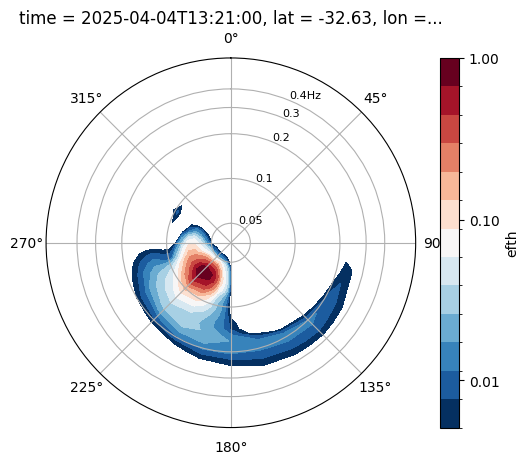

In [32]:
from wavespectra import read_swan

ds = read_swan(modeldir / "swan-20230101T000000.txt")
display(ds)
ds.squeeze().spec.plot()

### Wind

,tsec,wspd,wdir
2023-01-01 00:00:00,0.0,7.15,186.92
2023-01-01 01:00:00,3600.0,7.49,192.82
2023-01-01 02:00:00,7200.0,7.96,198.03
2023-01-01 03:00:00,10800.0,8.24,203.33
2023-01-01 04:00:00,14400.0,8.91,208.57
2023-01-01 05:00:00,18000.0,9.69,210.79
2023-01-01 06:00:00,21600.0,10.09,210.59
2023-01-01 07:00:00,25200.0,10.29,210.61
2023-01-01 08:00:00,28800.0,10.20,209.83
2023-01-01 09:00:00,32400.0,10.26,209.25


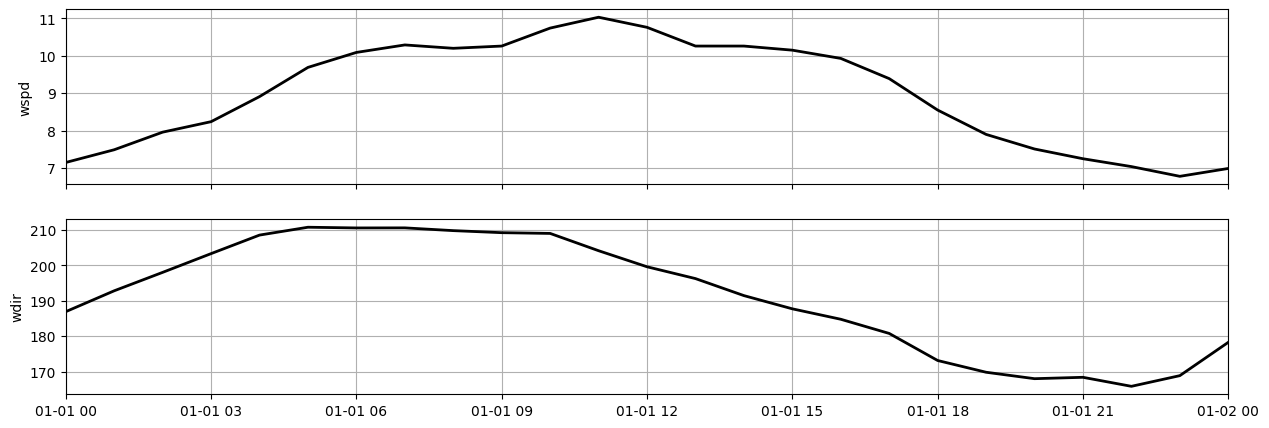

In [33]:
df = read_xbeach_input(modelrun, "windfile", ["tsec", "wspd", "wdir"])
display(df)
plot_xbeach_input(df, ["wspd", "wdir"])

### Tide

,tsec,zs
2023-01-01 00:00:00,0.0,-0.12
2023-01-01 01:00:00,3600.0,-0.10
2023-01-01 02:00:00,7200.0,-0.07
2023-01-01 03:00:00,10800.0,-0.04
2023-01-01 04:00:00,14400.0,0.00
2023-01-01 05:00:00,18000.0,0.05
2023-01-01 06:00:00,21600.0,0.09
2023-01-01 07:00:00,25200.0,0.14
2023-01-01 08:00:00,28800.0,0.17
2023-01-01 09:00:00,32400.0,0.20


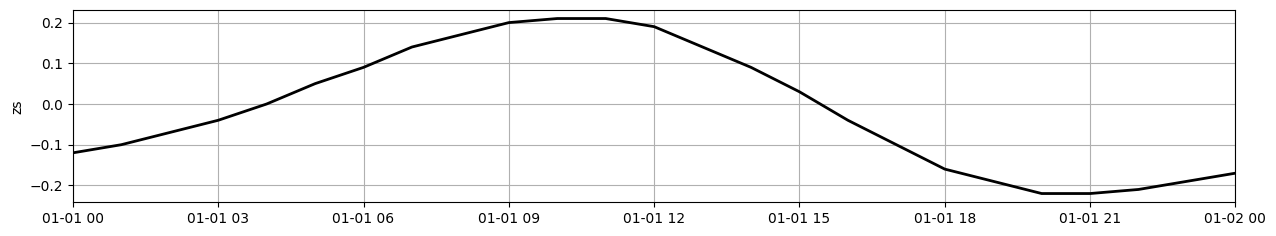

In [34]:
df = read_xbeach_input(modelrun, "zs0file", ["tsec", "zs"])
display(df)
plot_xbeach_input(df, ["zs"])

## Run the model

To be implemented

In [35]:
# !docker run  -v ./example_procedural/run1:/home rom-py/xbeach:dev params.txt > example_procedural/xbeach.log
# !tail example_procedural/xbeach.log

## Plot outputs

To be implemented

## Cleanup

Uncomment below to clean up the test workspace directory

In [36]:
# import shutil

# shutil.rmtree(workdir, ignore_errors=True)